# Stakeholder

A real estate company is looking to invest in non-luxury, single-family homes in King County, WA. They think this market will grow over time. They want information on several factors that influence the price of such homes.

In this project I define a non-luxury, single-family home as a house less than $3 million dollars, with over 1500 square feet of living space, and 3 or more bedrooms.

In [192]:
import pandas as pd
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import plotly.express as px
import geopy.distance

In [193]:
houses = pd.read_csv("data/kc_house_data.csv")

# Functions

I list all the functions I use in this project here. As a result, the rest of the project will be more readable.

In [235]:
def scatter(df, cols):
    fig, ax = plt.subplots(3,5, figsize=(25,10))
    fig.tight_layout(pad=3)

    for i in range(15):

        row = i//5
        col=i%5

        try:
            ax[row][col].scatter(df[cols[i]], df.price)
            ax[row][col].set_title(cols[i], size=15)
        except:
            break

In [233]:
def hist(df, cols):
    fig, ax = plt.subplots(1,5, figsize=(25,5))
    fig.tight_layout(pad=5.0)

    for i in range(5):

        row = i//5
        col=i%5

        ax[i].hist(df[cols[i]], bins=100)
        ax[i].set_title(cols[i], size=25)

In [266]:
def value_counts(df, cols):
    
    for col in cols:
        value_counts = dict(df[col].value_counts())
        for key in value_counts.keys():
            if value_counts[key] <= 10:
                df = df[~(df[col] == key)]
                
    return df

In [197]:
def variable_strength(df, var_list):
    col_dict = {"variables": var_list, "rsquared_adj": []}

    for col in var_list:
        model = sm.OLS.from_formula(f"price ~ {col}", data=df)
        results = model.fit()
        col_dict["rsquared_adj"].append(results.rsquared_adj)

    return pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

# Non-Linear Relationships with Price

The following variables have a non-linear relationship with price:

- Bedrooms
- Sqft_lot
- Sqft_garage
- Floors

The rest are roughly linear. The "floors" variable could be interpreted as having a negative linear relationship with price, but this makes no sense: how does a house's price go down when the number of floors go up? Such a relationship is suspect and I will therefore not include this variable in my model.

Before eliminating any variables from the dataset, I will use the "bedrooms" variable to include only the type of home we are looking at in this project: non-luxury, single-family homes. (Remember, we defined such a home to have 3 or more bedrooms, more than 1500 square feet of living space, and cost less than 3 million dollars.)

In [ ]:
houses['grade'] = houses['grade'].map(lambda x: x.split(" ")[0]).astype(int)
houses['waterfront'] = houses['waterfront'].map({'NO': 0, 'YES': 1})
houses['greenbelt'] = houses['greenbelt'].map({'NO': 0, 'YES': 1})
houses['nuisance'] = houses['nuisance'].map({'NO': 0, 'YES': 1})
houses['view'] = houses['view'].map({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'EXCELLENT': 3, 'FAIR': 4})
houses['condition'] = houses['condition'].map({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4})

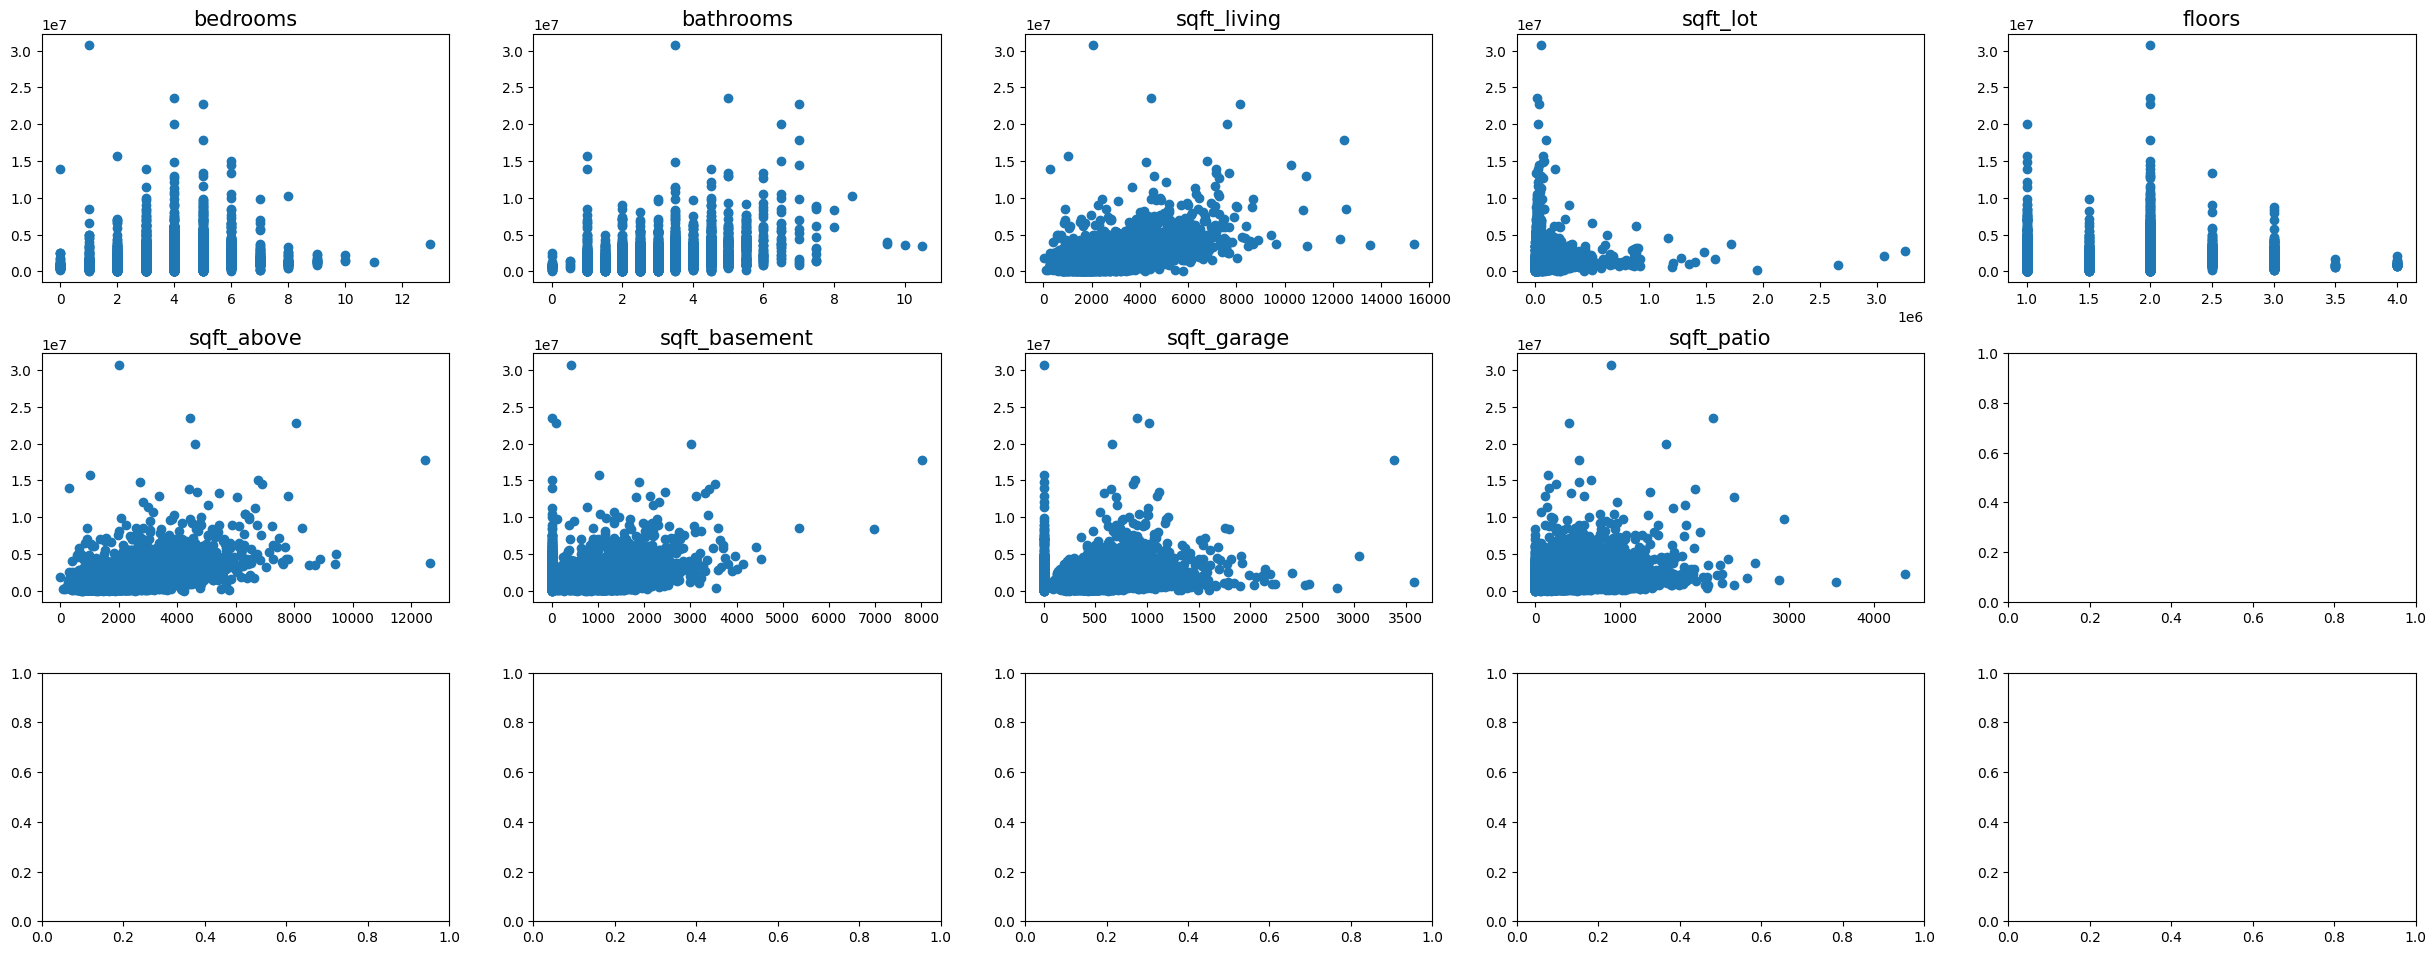

In [236]:
cols = ['bedrooms', 'bathrooms', 'sqft_living', 
        'sqft_lot', 'floors', 'sqft_above', 
        'sqft_basement', 'sqft_garage', 'sqft_patio']

scatter(houses, cols)

# Outliers

Any outliers can be seen via histograms of the numeric variables. Outliers in the categorical variables can be categories that have less than 10 values.

It seems like there are some outliers in all the variables we've listed below. Once we whittle our dataset down to single-family, non-luxury homes, the outliers in "price" will be eliminated, as will those in "sqft_living". The only variable we need to take care of are the "long" and "lat" variables.

The explanation for this comes from the description of the lat/long variables provided by Flatiron School:

``In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.``

It also seems like there are quite a few categories for each variable with less than 10 values. I will set 10 values as the threshold for a category being kept within a categorical variable.

Furthermore, since we are looking at "non-luxury" single family homes, we will drop the "Luxury" category from the "Grade" variable.

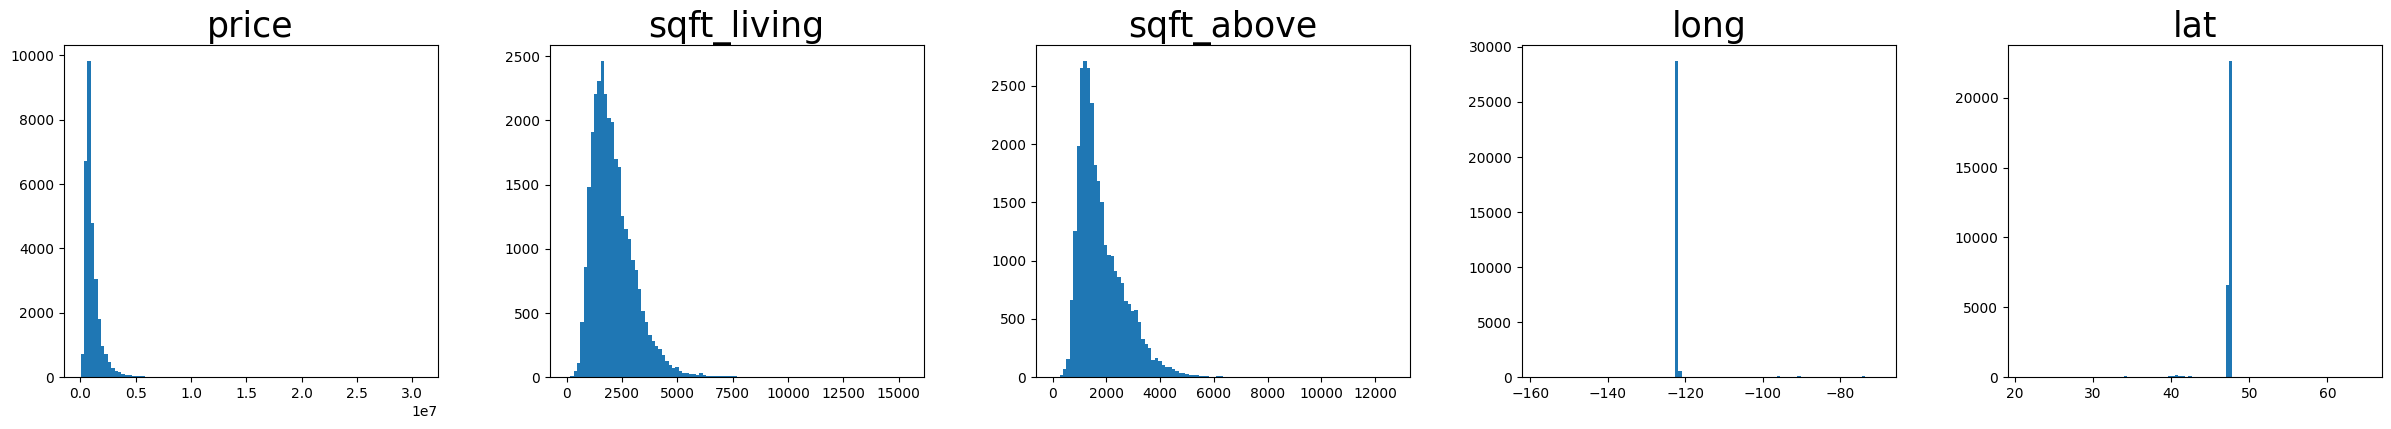

In [199]:
cols = ['price', 'sqft_living', 'sqft_above', 'long', 'lat']

hist(houses, cols)

In [200]:
for column in ['bedrooms', 'bathrooms', 'floors', 'condition', 'view', 'grade', 'heat_source', 'sewer_system']:
    print("\n" + column)
    print(houses[column].value_counts())


bedrooms
3     12754
4      9597
2      3936
5      2798
6       498
1       391
7        80
0        44
8        38
9        14
10        3
11        1
13        1
Name: bedrooms, dtype: int64

bathrooms
2.5     8475
2.0     7349
1.0     4576
3.0     4117
3.5     2266
1.5     1808
4.0      645
4.5      533
5.0      145
5.5      104
6.0       45
0.0       31
6.5       25
7.0       12
7.5       12
0.5        5
9.5        2
8.0        2
10.5       1
10.0       1
8.5        1
Name: bathrooms, dtype: int64

floors
1.0    13962
2.0    12265
1.5     2439
3.0     1222
2.5      222
4.0       30
3.5       15
Name: floors, dtype: int64

condition
Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

view
NONE         26589
AVERAGE       1915
GOOD           878
EXCELLENT      553
FAIR           220
Name: view, dtype: int64

grade
7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 V

# Feature Engineering

In this section we will create two new variables for our model based on the variables we already have: the average price by zipcode, and the density of the zipcode (how crowded it is).

A house's zipcode allows us to see how nearby houses are priced. This could be useful information in determining the price of a house. The density of a zipcode determines how crowded it is; this could also be a factor in how a house is priced.

The zipcodes are contained in the "address" variable. Each address is formatted like this:

``'houses number + street, city, state + zipcode, country'``

Extracting the zipcode only requires a pandas **map** method and python's built-in string-splitting functionality.

Once the zipcode is extracted, it will be placed in a column of its own. Then, for each house, we will calculate the average house price in its zipcode. Each house's price will be excluded from its own average, to avoid a house helping to predict its own price.

The density will just be the number of houses in the zipcode. We will only include zipcodes with more than 50 houses; this is an arbitrary cutoff point to ensure we are working with sufficient data. There were 73 unique zipcodes in total that had >50 houses.

In [201]:
houses['patio'] = houses['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
houses['basement'] = houses['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
houses['garage'] = houses['sqft_garage'].map(lambda x: 0 if x == 0 else 1)

In [202]:
houses['zipcode'] = houses.address.map(lambda x: x.split(',')[-2].split(' ')[-1])

houses = houses[houses.groupby('zipcode')['zipcode'].transform('count') > 50]

zipcode_prices = []
for i in range(len(houses)):
    zipcode = houses.iloc[i].zipcode
    identifier = houses.iloc[i].id
    subset = houses[(houses.zipcode == zipcode) & (houses.id != identifier)]
    zipcode_price = subset.price.mean()
    zipcode_prices.append(zipcode_price)
    
houses['zipcode_price'] = zipcode_prices

In [203]:
houses['density'] = houses.zipcode.map(dict(houses.zipcode.value_counts()))

# Eliminating collinearity

The next step is to determine good variables for inclusion in our model. Of those variables, we should take steps to prevent any that are highly correlated with each other from both being included in the model.

It seems like the grade, sqft_living, zipcode_price, sqft_above, bathrooms, view, waterfron, density, and heat_source variables are all decent candidates.

Of those variables, sqft_living is highly correlated with grade and bathrooms. We could either eliminate sqft_living, or eliminate grade and bathrooms. Since sqft_living is our best variable when it comes to predicting price, we will eliminate both grade and bathrooms from our model.

In [204]:
houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'patio', 'basement', 'garage',
       'zipcode', 'zipcode_price', 'density'],
      dtype='object')

In [239]:
var_list = ['bathrooms', 'sqft_living', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'patio', 'basement', 'garage', 'zipcode_price', 'density']

variable_strength(houses, var_list)

,variables,rsquared_adj
1,sqft_living,0.379907
11,zipcode_price,0.376722
7,grade,0.332360
0,bathrooms,0.237871
5,view,0.100465
2,waterfront,0.056859
12,density,0.027488
8,patio,0.022968
10,garage,0.012251
9,basement,0.011242


In [223]:
houses[list(strengths['variables'])].corr(numeric_only = True)

,sqft_living,zipcode_price,grade,bathrooms,view,waterfront,density,patio,garage,basement,greenbelt,condition,nuisance
sqft_living,1.000000,0.327841,0.738999,0.780186,0.228667,0.078942,-0.093007,0.277043,0.293865,0.102793,0.113719,-0.068318,-0.055569
zipcode_price,0.327841,1.000000,0.383847,0.267579,0.107674,0.039059,-0.268727,0.086095,0.063958,0.096277,0.062500,-0.007001,0.062103
grade,0.738999,0.383847,1.000000,0.653360,0.197305,0.047056,-0.083751,0.256536,0.356275,0.023312,0.121296,-0.147636,-0.066398
bathrooms,0.780186,0.267579,0.653360,1.000000,0.150790,0.043905,-0.050482,0.290093,0.340794,0.124788,0.094613,-0.064610,-0.051389
view,0.228667,0.107674,0.197305,0.150790,1.000000,0.401117,-0.106475,0.095534,-0.033702,0.177388,-0.015370,0.027608,0.027969
waterfront,0.078942,0.039059,0.047056,0.043905,0.401117,1.000000,-0.041877,0.043110,-0.064348,0.015561,-0.020385,-0.000050,0.009145
density,-0.093007,-0.268727,-0.083751,-0.050482,-0.106475,-0.041877,1.000000,-0.029674,0.075302,-0.053884,0.005884,0.012722,-0.034667
patio,0.277043,0.086095,0.256536,0.290093,0.095534,0.043110,-0.029674,1.000000,0.121614,0.087775,0.056009,-0.023202,-0.052457
garage,0.293865,0.063958,0.356275,0.340794,-0.033702,-0.064348,0.075302,0.121614,1.000000,-0.096117,0.101108,-0.079842,-0.136805
basement,0.102793,0.096277,0.023312,0.124788,0.177388,0.015561,-0.053884,0.087775,-0.096117,1.000000,-0.050635,0.068174,0.110338


# Data Cleaning

After exploring the data a bit, we have decided to:

- Hone the dataset down to homes costing less than 3 million, with >1500 sqft of living space, and 3 or more bedrooms
- Eliminate bedrooms, sqft_lot, sqft_garage, and floors due to non-linear relationships with price
- Only include houses with a longitude between -125 and -120 and a latitude between 47 and 48; anything else is outside King County and not relevant
- Eliminate grade and bathrooms because they correlate highly with sqft_living.
- Eliminate any categories from the following variables that have <10 members
    - bedrooms
    - bathrooms
    - floors
    - condition
    - view
    - grade
    - heat_source
    - sewer_system

In [269]:
houses = houses.drop(houses.query('bedrooms < 3 or \
                      sqft_living < 1500 or\
                      price > 3_000_000').index)

cols = ['bedrooms', 'bathrooms', 'floors', 'condition', 'view', 'grade', 'heat_source', 'sewer_system']
houses = value_counts(houses, cols)

houses.drop(['sqft_lot', 'sqft_garage', 'floors', 'grade', 'bathrooms'], axis=1, inplace=True)

houses = houses.query('long > -125 & long < -120 & lat > 47 & lat < 48')

# Model 1


This first model is our base model, and it uses only the best variable. It came out with an R-Squared of 0.316. This is hardly good enough, even though both the parameters (intercept, and sqft_living) are statistically significant. Furthermore, our MAE and RMSE are both huge.

In [271]:
model = sm.OLS.from_formula(f"price ~ sqft_living", data=houses)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     8992.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:54:50   Log-Likelihood:            -2.8183e+05
No. Observations:               19483   AIC:                         5.637e+05
Df Residuals:                   19481   BIC:                         5.637e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.075e+05   1.14e+04      9.427      

# Model 2

In this model, we included many more variables. Our model's adjusted R-squared increased from <0.4 to 0.634, a huge improvement. Our MAE and RMSE are still large, but much smaller than that of the previous model.

Initially, I included the "basement" and "patio" variables in this model, but they were not statistically significant, so I removed them (with no difference in adjusted R-squared or other model metrics).

In [275]:
model = sm.OLS.from_formula(f"price ~ sqft_living + zipcode_price + view + waterfront + density + garage", data=houses)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     5618.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:58:56   Log-Likelihood:            -2.7574e+05
No. Observations:               19483   AIC:                         5.515e+05
Df Residuals:                   19476   BIC:                         5.516e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.878e+05   1.25e+04    -31.000